In [6]:
import torch
import numpy as np
import json
import math
import pickle
from tqdm import tqdm
from typing import List, Dict, Tuple

print(torch.__version__)

2.2.0+cu121


In [7]:
fp2_dict = json.load(open('frags_to_spec_24.json', 'r'))#Dataset_preparation2

In [8]:
specs_vocab_size = 270 
SPECS_BOS_TOKEN = specs_vocab_size
SPECS_EOS_TOKEN = specs_vocab_size + 1
SPECS_PAD_TOKEN = specs_vocab_size + 2


UNK = 0
frags_vocab_size = len(fp2_dict)+1
FRAGS_BOS_TOKEN = frags_vocab_size
FRAGS_EOS_TOKEN = frags_vocab_size + 1
FRAGS_PAD_TOKEN = frags_vocab_size + 2

In [9]:
class Frags2SpecDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data : List[Dict[str, List[int]]]
    ) -> None:
        
        self.spectrums = []
        self.frags = []
        
        for cur in tqdm(data):
            self.spectrums.append(
                torch.cat([
                    torch.tensor([SPECS_BOS_TOKEN], dtype=torch.int64),
                    self._get_labels_from_spectrum(
                        torch.tensor(
                            cur['spectrum'],
                            dtype=torch.int64
                        )
                    ),
                    torch.tensor([SPECS_EOS_TOKEN], dtype=torch.int64)
                ])
            )
            self.frags.append(
                torch.cat([
                    torch.tensor([FRAGS_BOS_TOKEN], dtype=torch.int64),
                    torch.tensor(
                        cur['frags'],
                        dtype=torch.int64
                    ),
                    torch.tensor([FRAGS_EOS_TOKEN], dtype=torch.int64)
                ])
            )

    def _get_labels_from_spectrum(
        self,
        spectrum : torch.Tensor
    ) -> torch.Tensor:
        res = []
        for idx in (spectrum > 0).nonzero().flatten():
            res.extend([idx] * spectrum[idx])
        return torch.stack(res)

    def __len__(
        self
    ) -> int:
        return len(self.spectrums)

    def __getitem__(
        self,
        idx
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.frags[idx],self.spectrums[idx]

In [10]:
with open('data/dataset_frags_to_spec_24.pkl', 'rb') as file: 
    dataset = pickle.load(file) 

In [11]:
with open('data/train_idxs_24THR.pkl', 'rb') as file: 
    train_idxs = pickle.load(file) 
with open('data/val_idxs_24THR.pkl', 'rb') as file: 
    val_idxs = pickle.load(file) 

In [12]:
assert val_idxs.shape[0] + train_idxs.shape[0] == len(dataset)
assert np.intersect1d(val_idxs, train_idxs).shape[0] == 0
train_set = torch.utils.data.Subset(dataset, train_idxs)
val_set = torch.utils.data.Subset(dataset, val_idxs)

In [13]:
def collate_fn(
    data : List[Tuple[torch.Tensor, torch.Tensor]]
):
    specs = []
    frags = []
    for cur in data:
        specs.append(cur[1])
        frags.append(cur[0])
    return (
        torch.nn.utils.rnn.pad_sequence(
            frags, 
            batch_first=True, 
            padding_value=FRAGS_PAD_TOKEN
        ),
        torch.nn.utils.rnn.pad_sequence(
            specs, 
            batch_first=True, 
            padding_value=SPECS_PAD_TOKEN
        )
    )

In [14]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1024, shuffle=False, collate_fn=collate_fn)

In [15]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = torch.nn.Linear(d_model, d_model)
        self.W_k = torch.nn.Linear(d_model, d_model)
        self.W_v = torch.nn.Linear(d_model, d_model)
        self.W_o = torch.nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

class PositionWiseFeedForward(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = torch.nn.Linear(d_model, d_ff)
        self.fc2 = torch.nn.Linear(d_ff, d_model)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

class Transformer(torch.nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = torch.nn.Embedding(src_vocab_size, d_model).to(device)
        self.decoder_embedding = torch.nn.Embedding(tgt_vocab_size, d_model).to(device)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = torch.nn.Linear(d_model, tgt_vocab_size)
        self.dropout = torch.nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != FRAGS_PAD_TOKEN).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != SPECS_PAD_TOKEN).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
device

'cuda'

In [17]:
import torch.nn.functional as F

class CustomCrossEntropy(torch.nn.Module):
    def __init__(self):
        super(CustomCrossEntropy, self).__init__()

    def forward(self, input, target):
        # input  (batch_size, sequence_length, vocab_size)
        # target  (batch_size, sequence_length)

        batch_size, sequence_length, vocab_size = input.shape

       
        distances = torch.abs(
            torch.arange(vocab_size, device=input.device).unsqueeze(0).unsqueeze(0) - target.unsqueeze(-1)
        )  # distances: (batch_size, sequence_length, vocab_size)

        # calculate the probabilities by the formula (1 - distance / 4) ** 2
        probs = torch.where(
            distances <= 3,
            (1 - distances / 4) ** 2,
            torch.tensor(0.0, device=input.device)
        )  # probs: (batch_size, sequence_length, vocab_size)

  
        probs.scatter_(2, target.unsqueeze(-1), 1.0)

   
        probs = probs / probs.sum(dim=-1, keepdim=True)

       
        loss = F.cross_entropy(input.view(-1, vocab_size), probs.view(-1, vocab_size))

        return loss

In [18]:
model = Transformer(src_vocab_size=frags_vocab_size+3,
                    tgt_vocab_size=270+3,
                    d_model=256,
                    num_heads=8,
                    num_layers=4,
                    d_ff=256,
                    max_seq_length=158,
                    dropout=0.2
                    )
model.to(device)

optimizer  = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = CustomCrossEntropy()

In [14]:
from tqdm.auto import tqdm
train_loss =[]
valid_loss =[]
epochs = 100
for epoch in tqdm(range(epochs)):
    train_loss_current = []
    model.train()
    for idx, (X, y) in enumerate(train_loader):
        preds = model(
            src=X.to(device),
            tgt=y[:, :-1].to(device)
        )
        loss = criterion(
            preds, 
            y.contiguous()[:, 1:].to(device)
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
        train_loss_current.append(loss.item())

    train_loss.append(np.mean(train_loss_current))
    
    valid_loss_current = []
    model.eval()
    with torch.inference_mode():
        for idx, (X, y) in enumerate(val_loader):
            preds = model(
                X.to(device),
                y[:, :-1].to(device)
            )
            loss = criterion(
                preds, 
                y.contiguous()[:, 1:].to(device)
            )  
            valid_loss_current.append(loss.item())
    valid_loss.append(np.mean(valid_loss_current))
    
    print(f'Эпоха - {epoch+1}, train_loss - {train_loss[-1]}, valid_loss - {valid_loss[-1]}')

  0%|          | 0/100 [00:00<?, ?it/s]

Эпоха - 1, train_loss - 1.8006146707445243, valid_loss - 1.6443036379439107


Эпоха - 2, train_loss - 1.6204923030915954, valid_loss - 1.5819597967555015


Эпоха - 3, train_loss - 1.5805181422703702, valid_loss - 1.5563045150778267


Эпоха - 4, train_loss - 1.5571347519825323, valid_loss - 1.538500972454914


Эпоха - 5, train_loss - 1.539157450255094, valid_loss - 1.52442020066222


Эпоха - 6, train_loss - 1.524202914081269, valid_loss - 1.5091721323991982


Эпоха - 7, train_loss - 1.515641077247584, valid_loss - 1.4987776801827248


Эпоха - 8, train_loss - 1.5054207665259849, valid_loss - 1.492706794863783


Эпоха - 9, train_loss - 1.4994984611099316, valid_loss - 1.4875318401315238


Эпоха - 10, train_loss - 1.4930371469175312, valid_loss - 1.48438357726465


Эпоха - 11, train_loss - 1.486344252953507, valid_loss - 1.4768102959300695


Эпоха - 12, train_loss - 1.4820944898005382, valid_loss - 1.4744428655181485


Эпоха - 13, train_loss - 1.4780915503210865, valid_loss - 1.4735428456510051


Эпоха - 14, train_loss - 1.4731138457714672, valid_loss - 1.470468092054017


Эпоха - 15, train_loss - 1.4694992140425203, valid_loss - 1.4631575886229897


Эпоха - 16, train_loss - 1.4663637915687382, valid_loss - 1.4596738650111223


Эпоха - 17, train_loss - 1.4631957921623624, valid_loss - 1.4555137001173326


Эпоха - 18, train_loss - 1.4596893785145362, valid_loss - 1.4539330175306913


Эпоха - 19, train_loss - 1.4571014613612716, valid_loss - 1.4513103506538305


Эпоха - 20, train_loss - 1.4544829721182164, valid_loss - 1.4482438640201583


Эпоха - 21, train_loss - 1.452473769277474, valid_loss - 1.4478165956025713


Эпоха - 22, train_loss - 1.4517122783571341, valid_loss - 1.4462313089477883


Эпоха - 23, train_loss - 1.4485316208270793, valid_loss - 1.4441262421090058


Эпоха - 24, train_loss - 1.4458897026491837, valid_loss - 1.4436970533949605


Эпоха - 25, train_loss - 1.445460456749643, valid_loss - 1.4431767767288266


Эпоха - 26, train_loss - 1.4425472755387356, valid_loss - 1.4399667866667558


Эпоха - 27, train_loss - 1.4410877701262352, valid_loss - 1.4385611287663491


Эпоха - 28, train_loss - 1.4402415441235465, valid_loss - 1.436098809099376


Эпоха - 29, train_loss - 1.4368338825557154, valid_loss - 1.4344881219363839


Эпоха - 30, train_loss - 1.4358924595962668, valid_loss - 1.435534076744251


Эпоха - 31, train_loss - 1.4352295689739532, valid_loss - 1.4322204129972709


Эпоха - 32, train_loss - 1.4332402514739775, valid_loss - 1.4376558931579304


Эпоха - 33, train_loss - 1.4319521167468576, valid_loss - 1.432771124643333


Эпоха - 34, train_loss - 1.4313107244285619, valid_loss - 1.4297196494506093


Эпоха - 35, train_loss - 1.429531931093601, valid_loss - 1.4295755236336354


Эпоха - 36, train_loss - 1.4293970425923666, valid_loss - 1.4288707583138112


Эпоха - 37, train_loss - 1.4275609703690793, valid_loss - 1.4298956711194042


Эпоха - 38, train_loss - 1.4271419950494184, valid_loss - 1.4259786654947402


Эпоха - 39, train_loss - 1.425818894950437, valid_loss - 1.4285028163859907


Эпоха - 40, train_loss - 1.424882245847317, valid_loss - 1.42545511927944


Эпоха - 41, train_loss - 1.4243379487677919, valid_loss - 1.4258294346627225


Эпоха - 42, train_loss - 1.4223608149049427, valid_loss - 1.42569104830424


Эпоха - 43, train_loss - 1.4210450539566541, valid_loss - 1.4232890043365822


Эпоха - 44, train_loss - 1.4218633167060888, valid_loss - 1.424914750713534


Эпоха - 45, train_loss - 1.4208126155423446, valid_loss - 1.4210565344671184


Эпоха - 46, train_loss - 1.418863663091346, valid_loss - 1.4229207583581016


Эпоха - 47, train_loss - 1.4191278134153482, valid_loss - 1.4202338251728244


Эпоха - 48, train_loss - 1.416592727804408, valid_loss - 1.422038341729382


Эпоха - 49, train_loss - 1.417003931238058, valid_loss - 1.420374653759074


Эпоха - 50, train_loss - 1.4172998258205647, valid_loss - 1.4184296899074025


Эпоха - 51, train_loss - 1.4145106415233701, valid_loss - 1.4204309625125557


Эпоха - 52, train_loss - 1.4139891593109275, valid_loss - 1.4212440252304077


Эпоха - 53, train_loss - 1.414464839523387, valid_loss - 1.4169689381167236


Эпоха - 54, train_loss - 1.412604229550966, valid_loss - 1.4185398245572152


Эпоха - 55, train_loss - 1.4121632533454, valid_loss - 1.4169599969735307


Эпоха - 56, train_loss - 1.4118782558351615, valid_loss - 1.4163915910077898


Эпоха - 57, train_loss - 1.4108113283282715, valid_loss - 1.4179269298632047


Эпоха - 58, train_loss - 1.4110472774281748, valid_loss - 1.4144493917400918


Эпоха - 59, train_loss - 1.4087897507797384, valid_loss - 1.4158497968416535


Эпоха - 60, train_loss - 1.4099588068438247, valid_loss - 1.4155947286984447


Эпоха - 61, train_loss - 1.4090320133827101, valid_loss - 1.4152533458859733


Эпоха - 62, train_loss - 1.4076269239327157, valid_loss - 1.4142271490132765


Эпоха - 63, train_loss - 1.4070915591548865, valid_loss - 1.4125693402486794


Эпоха - 64, train_loss - 1.406985288942364, valid_loss - 1.4156612930226415


Эпоха - 65, train_loss - 1.4062740340479103, valid_loss - 1.411979106481602


Эпоха - 66, train_loss - 1.4054782400668506, valid_loss - 1.4115790177820327


Эпоха - 67, train_loss - 1.4047898598120245, valid_loss - 1.4116453160060924


Эпоха - 68, train_loss - 1.404278081907353, valid_loss - 1.4127138995945676


Эпоха - 69, train_loss - 1.4042162554924478, valid_loss - 1.4116089973556862


Эпоха - 70, train_loss - 1.4037918342670925, valid_loss - 1.4129842269733157


Эпоха - 71, train_loss - 1.402814132394925, valid_loss - 1.4126353844274742


Эпоха - 72, train_loss - 1.4029996559653484, valid_loss - 1.4102797115340215


Эпоха - 73, train_loss - 1.4017886015171177, valid_loss - 1.4106358115592699


Эпоха - 74, train_loss - 1.4022115794705674, valid_loss - 1.410991831665182


Эпоха - 75, train_loss - 1.4016002709876763, valid_loss - 1.4078596633918277


Эпоха - 76, train_loss - 1.4010571138399868, valid_loss - 1.4100581653109203


Эпоха - 77, train_loss - 1.4003556495541138, valid_loss - 1.408556655998087


Эпоха - 78, train_loss - 1.4007586159056902, valid_loss - 1.4071571237585518


Эпоха - 79, train_loss - 1.3994818588937392, valid_loss - 1.410073229882601


Эпоха - 80, train_loss - 1.399900779813668, valid_loss - 1.4099665594458133


Эпоха - 81, train_loss - 1.3992485615009433, valid_loss - 1.4064111437243916


Эпоха - 82, train_loss - 1.3984173817254009, valid_loss - 1.4070107624325412


Эпоха - 83, train_loss - 1.397755569695307, valid_loss - 1.407059501172898


Эпоха - 84, train_loss - 1.3971438088887174, valid_loss - 1.406516896205002


Эпоха - 85, train_loss - 1.3968019941043406, valid_loss - 1.4054785524861197


Эпоха - 86, train_loss - 1.396386337392207, valid_loss - 1.4058689383531777


Эпоха - 87, train_loss - 1.3964634163278928, valid_loss - 1.406813573747985


Эпоха - 88, train_loss - 1.3962103074705097, valid_loss - 1.4070486089263516


Эпоха - 89, train_loss - 1.3955591829729752, valid_loss - 1.4067918450644847


Эпоха - 90, train_loss - 1.3953111768328528, valid_loss - 1.4063473060336453


Эпоха - 91, train_loss - 1.395351938798394, valid_loss - 1.4050717693143122


Эпоха - 92, train_loss - 1.394106553417976, valid_loss - 1.4059041198273277


Эпоха - 93, train_loss - 1.3939898886031388, valid_loss - 1.4068998209992598


Эпоха - 94, train_loss - 1.3936820541748978, valid_loss - 1.4035495653581083


Эпоха - 95, train_loss - 1.3934102594572613, valid_loss - 1.4033595060141346


Эпоха - 96, train_loss - 1.3934550637930212, valid_loss - 1.4043541463573328


Эпоха - 97, train_loss - 1.3925311004611807, valid_loss - 1.405388325787662


Эпоха - 98, train_loss - 1.3923837743454697, valid_loss - 1.4024345758702426


Эпоха - 99, train_loss - 1.3917422158057702, valid_loss - 1.4052041978871779


Эпоха - 100, train_loss - 1.3920096211590118, valid_loss - 1.4031479925698556


In [15]:
f= 'data/Frags_to_Spec_lossfn_1_24THR_moretrain.model'
torch.save(model.state_dict(), f)

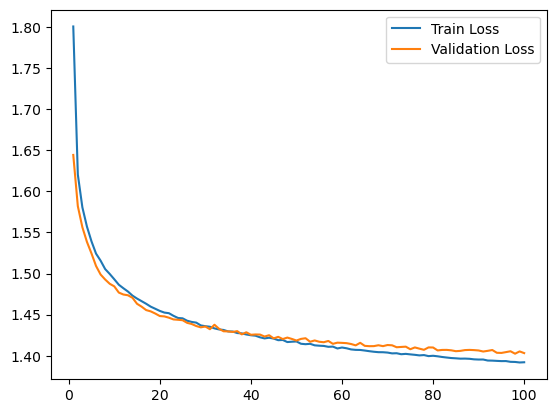

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

tr = {i+1:v for i,v in enumerate(train_loss)}
val = {i+1:v for i,v in enumerate(valid_loss)}

sns.lineplot(data=tr, label=str('Train Loss'))
sns.lineplot(data=val, label=str('Validation Loss'))
plt.legend()
plt.show()

In [43]:
model.load_state_dict(torch.load('data/Frags_to_Spec_lossfn_1_24THR_moretrain.model', weights_only=True,map_location=torch.device('cpu')))
model.to(device)
model.eval()

Transformer(
  (encoder_embedding): Embedding(49797, 256)
  (decoder_embedding): Embedding(273, 256)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-3): 4 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=256, out_features=256, bias=True)
        (W_k): Linear(in_features=256, out_features=256, bias=True)
        (W_v): Linear(in_features=256, out_features=256, bias=True)
        (W_o): Linear(in_features=256, out_features=256, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=256, out_features=256, bias=True)
        (fc2): Linear(in_features=256, out_features=256, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-3): 4 x DecoderLayer(
   

In [85]:
with open('data/big_test_dataset_24.pkl', 'rb') as file: 
    test_dataset_24 = pickle.load(file) 

In [86]:
from data.testing__ import predict_and_test,plot_violin

In [88]:
df,predict_dict,padded_predictions = predict_and_test(test_dataset=test_dataset_24,
                                                              num=100000,
                                                              SPECS_BOS_TOKEN=SPECS_BOS_TOKEN,
                                                              SPECS_EOS_TOKEN=SPECS_EOS_TOKEN,
                                                              model=model,
                                                              FRAGS_PAD_TOKEN=FRAGS_PAD_TOKEN,
                                                              SPECS_PAD_TOKEN=SPECS_PAD_TOKEN,
                                                              device=device)

Predicted  tensor([52, 73, 84]) | Real  tensor([52, 73, 84])
Predicted  tensor([147, 149, 149, 156]) | Real  tensor([147, 147, 149, 155])
Predicted  tensor([149, 150, 154, 156, 212]) | Real  tensor([149, 150, 154, 156, 212])
Predicted  tensor([ 42, 150, 150, 154, 166, 212]) | Real  tensor([ 42, 149, 150, 154, 165, 212])
Predicted  tensor([148, 149, 149, 151, 154, 173, 214]) | Real  tensor([148, 148, 149, 151, 154, 173, 214])
Predicted  tensor([121, 129, 137, 139, 150, 152, 161, 181]) | Real  tensor([122, 130, 135, 138, 142, 154, 184, 187])
Predicted  tensor([ 38,  44,  46,  51,  80,  82,  87,  89, 117]) | Real  tensor([ 38,  45,  48,  51,  76,  81,  89,  91, 118])
Predicted  tensor([ 32,  50,  55, 146, 148, 148, 148, 162, 164, 193]) | Real  tensor([ 32,  51,  54, 146, 148, 148, 148, 161, 164, 194])
Predicted  tensor([127, 132, 135, 143, 146, 148, 152, 153, 160, 182, 188]) | Real  tensor([130, 133, 138, 143, 147, 148, 150, 153, 161, 186, 187])


Matching lengths - 93652, mismatch - 6348

In [92]:
df['MAE'].mean()

0.6754349568408801

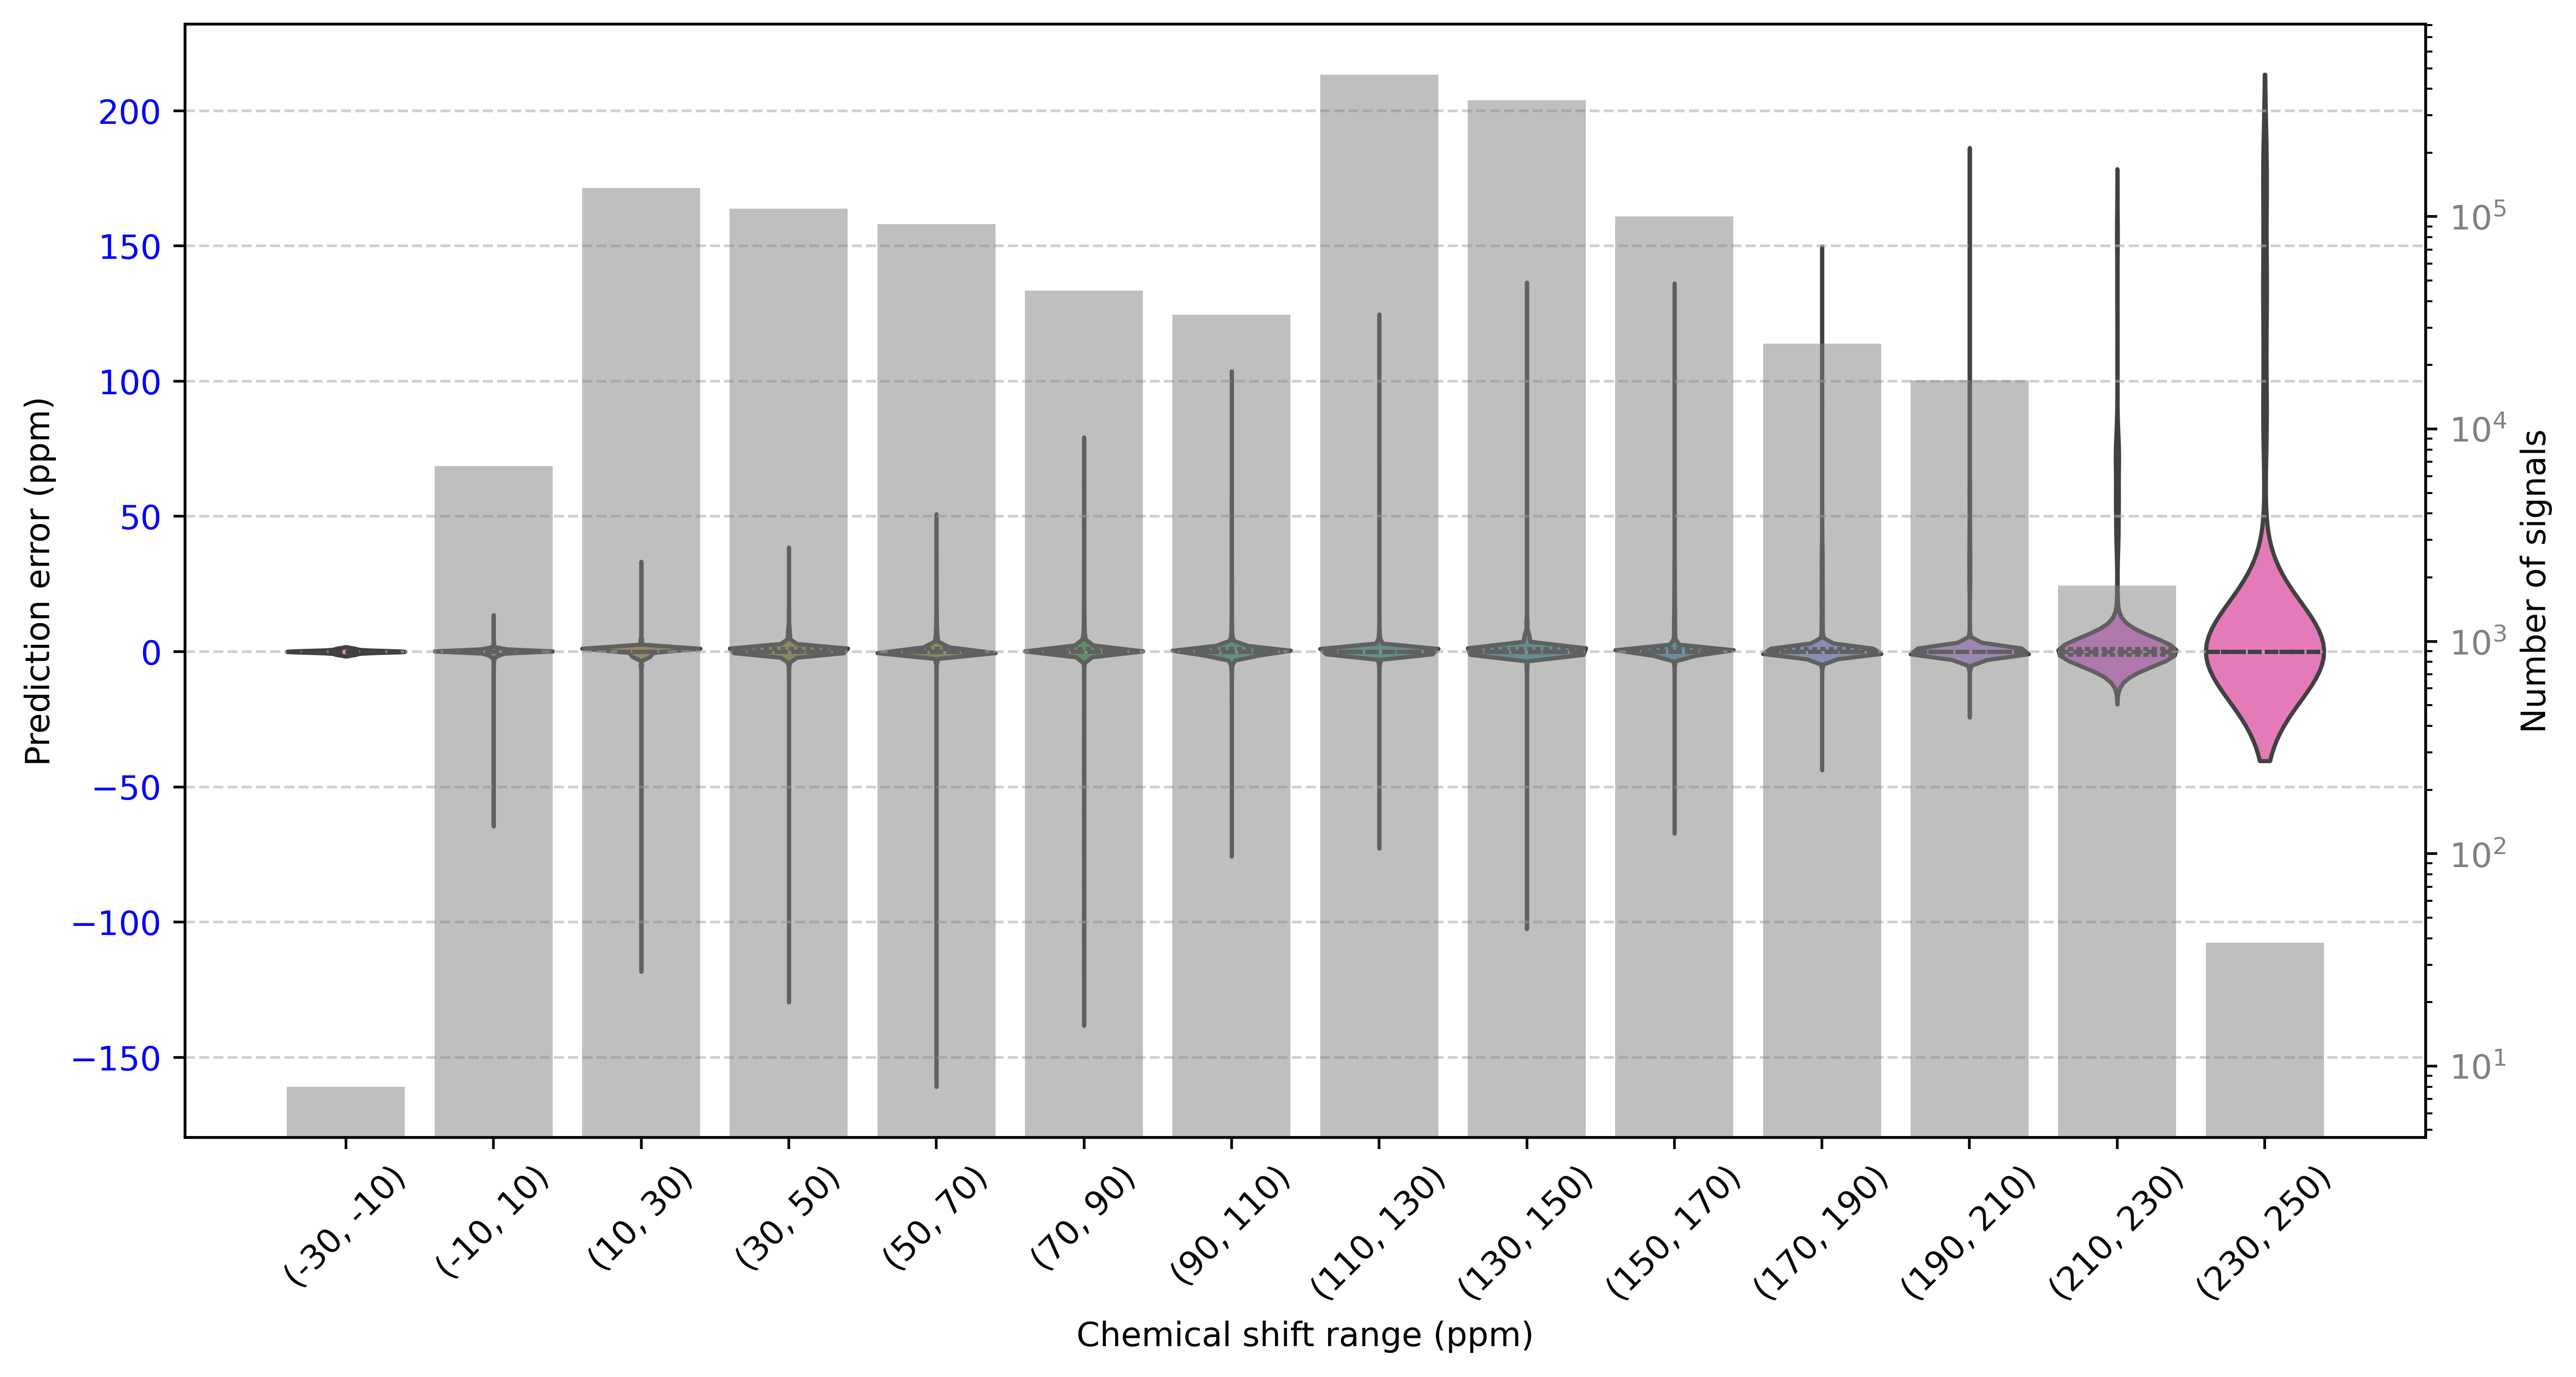

In [90]:
plot_violin(padded_predictions)